# Hierarchical Model Performance Test

This notebook should be executed with a kernel with Python 3.12. All library dependencies are on requirementsv312.txt file.

In [ ]:
#!pip install -r requirementsv312.txt

  Using cached seaborn-0.13.2-py3-none-any.whl.metadata (5.4 kB)
Using cached seaborn-0.13.2-py3-none-any.whl (294 kB)


In [32]:
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from xgboost import XGBClassifier
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE

In [9]:
data = pd.read_csv('Datasets/Complete/Dataset.csv')

X = data.drop('AttackType', axis=1)
y = data['AttackType']

target_classes = {
    "BruteForce": 50000,
    "XSS": 50000,
    "SQLInjection": 50000
}

smote = SMOTE(sampling_strategy=target_classes, random_state=42)
X_resampled, y_resampled = smote.fit_resample(X, y)

# Join X_resampled and y_resampled
df_resampled = pd.concat([X_resampled, y_resampled], axis=1)

# Save to Dataset.csv
df_resampled.to_csv('Datasets/Complete/Dataset.csv', index=False)

/Users/nico/Desktop/UPC/PAE/SentinelX/.venv/lib/python3.9/site-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
/Users/nico/Desktop/UPC/PAE/SentinelX/.venv/lib/python3.9/site-packages/sklearn/utils/_tags.py:354: FutureWarning: The SMOTE or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an error.
  warnings.warn(


In [10]:
y_resampled_lvl1 = y_resampled.apply(lambda x: 'MALIGN' if x != 'BENIGN' else x)
X_resampled_lvl1 = X_resampled.copy()

y_resampled_lvl2 = y_resampled[y_resampled_lvl1 == 'MALIGN']
y_resampled_lvl2 = y_resampled_lvl2.apply(lambda x: 'WebAttack' if x in ['XSS', 'SQLInjection', 'BruteForce'] else x)
X_resampled_lvl2 = X_resampled[y_resampled_lvl1 == 'MALIGN']

y_resampled_lvl3 = y_resampled[y_resampled.isin(['XSS', 'SQLInjection', 'BruteForce'])]
X_resampled_lvl3 = X_resampled[y_resampled.isin(['XSS', 'SQLInjection', 'BruteForce'])]

print(y_resampled_lvl3.value_counts())

AttackType
BruteForce      50000
XSS             50000
SQLInjection    50000
Name: count, dtype: int64


In [11]:
# Encode labels for level 2
label_encoder_lvl2 = LabelEncoder()
y_resampled_lvl2_encoded = label_encoder_lvl2.fit_transform(y_resampled_lvl2)

# Encode labels for level 3
label_encoder_lvl3 = LabelEncoder()
y_resampled_lvl3_encoded = label_encoder_lvl3.fit_transform(y_resampled_lvl3)

In [12]:
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42)

#  Split data for level 1 model
X_train_lvl1, X_test_lvl1, y_train_lvl1, y_test_lvl1 = train_test_split(X_resampled_lvl1, y_resampled_lvl1, test_size=0.2, random_state=42)

# Split data for level 2 model
X_train_lvl2, X_test_lvl2, y_train_lvl2, y_test_lvl2 = train_test_split(X_resampled_lvl2, y_resampled_lvl2_encoded, test_size=0.2, random_state=42)

# Split data for level 3 model
X_train_lvl3, X_test_lvl3, y_train_lvl3, y_test_lvl3 = train_test_split(X_resampled_lvl3, y_resampled_lvl3_encoded, test_size=0.2, random_state=42)

In [13]:
model_lvl1 = rf = RandomForestClassifier(n_estimators=100, random_state=42)
model_lvl1.fit(X_train_lvl1, y_train_lvl1)

y_pred_lvl1 = model_lvl1.predict(X_test_lvl1)

In [14]:
lvl1_mask = y_pred_lvl1 == 'MALIGN'

In [15]:
model_lvl2 = MLPClassifier(random_state=42, max_iter=300)
model_lvl2.fit(X_train_lvl2, y_train_lvl2)

MLPClassifier(max_iter=300, random_state=42)

In [16]:
X_test_lvl2 = X_test_lvl1[lvl1_mask]

y_pred_lvl2 = model_lvl2.predict(X_test_lvl2)

y_pred_lvl2 = label_encoder_lvl2.inverse_transform(y_pred_lvl2)

y_pred_lvl1[lvl1_mask] = y_pred_lvl2

lvl2_mask = y_pred_lvl1 == 'WebAttack'



In [17]:
import xgboost as xgb

xgb_model = xgb.XGBClassifier(
    colsample_bytree=1.0,
    learning_rate=0.2,
    max_depth=9,
    n_estimators=200,
    subsample=1.0,
    random_state=42
)


model_lvl3 = xgb_model
model_lvl3.fit(X_train_lvl3, y_train_lvl3)



/Users/nico/Desktop/UPC/PAE/SentinelX/.venv/lib/python3.9/site-packages/sklearn/utils/_tags.py:354: FutureWarning: The XGBClassifier or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an error.
  warnings.warn(


AttributeError: 'super' object has no attribute '__sklearn_tags__'

AttributeError: 'super' object has no attribute '__sklearn_tags__'

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=1.0, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.2, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=9, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=200, n_jobs=None,
              num_parallel_tree=None, objective='multi:softprob', ...)

In [18]:
X_test_lvl3 = X_test_lvl1[lvl2_mask]

y_pred_lvl3 = model_lvl3.predict(X_test_lvl3)

y_pred_lvl3 = label_encoder_lvl3.inverse_transform(y_pred_lvl3)

y_pred_lvl1[lvl2_mask] = y_pred_lvl3

y_pred_final = y_pred_lvl1



print(classification_report(y_test, y_pred_final))


              precision    recall  f1-score   support

      BENIGN       0.99      1.00      1.00     78452
  BruteForce       0.97      0.93      0.95     10037
        DDoS       1.00      1.00      1.00     25788
    PortScan       1.00      1.00      1.00     31733
SQLInjection       0.97      0.99      0.98     10015
         XSS       0.98      0.99      0.98      9947

    accuracy                           0.99    165972
   macro avg       0.99      0.98      0.99    165972
weighted avg       0.99      0.99      0.99    165972



In [19]:
import joblib

# Guardar los modelos
joblib.dump(model_lvl1, 'LayerModels/model_lvl1_rf.joblib')
joblib.dump(model_lvl2, 'LayerModels/model_lvl2_mlp.joblib')
joblib.dump(model_lvl3, 'LayerModels/model_lvl3_xgb.joblib')

# Guardar los label encoders
joblib.dump(label_encoder_lvl2, 'LayerModels/label_encoder_lvl2.joblib')
joblib.dump(label_encoder_lvl3, 'LayerModels/label_encoder_lvl3.joblib')

print("Modelos y label encoders guardados.")

Modelos y label encoders guardados.


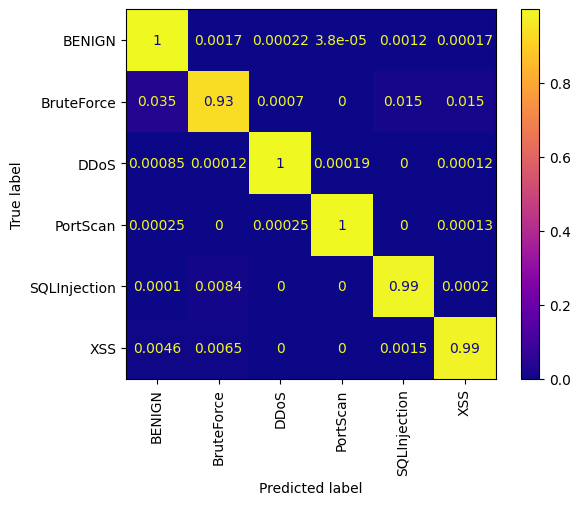

In [39]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Compute normalized confusion matrix
cm_normalized = confusion_matrix(y_test, y_pred_final, normalize='true')

# Plot normalized confusion matrix with a vibrant colormap
disp_normalized = ConfusionMatrixDisplay(confusion_matrix=cm_normalized, display_labels=np.unique(y_test))
disp_normalized.plot(cmap='plasma')  # You can use other colormaps like 'plasma', 'inferno', 'magma', etc.
plt.xticks(rotation=90)
plt.show()

/var/folders/1c/k17dvp9157q8zrkvz60k2wsm0000gn/T/ipykernel_7295/901128697.py:22: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df_precision, x='Clase', y='Precision', palette='Set2')


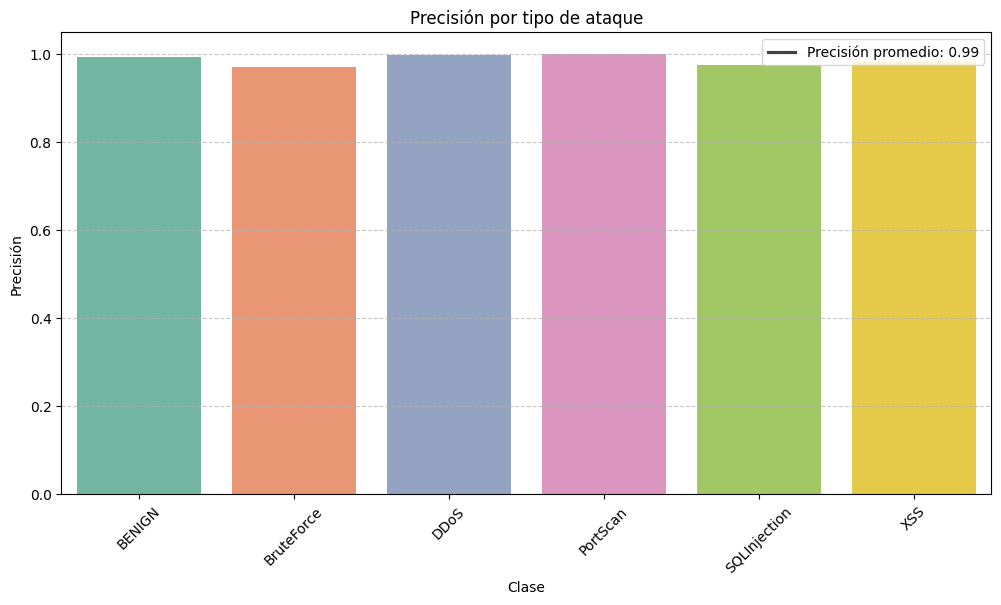

In [41]:
from sklearn.metrics import classification_report
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Obtén el reporte de clasificación como un diccionario
report = classification_report(y_test, y_pred_final, target_names=[str(c) for c in classes], output_dict=True)

# Crea un DataFrame con las métricas por clase
df_metrics = pd.DataFrame(report).T
df_metrics = df_metrics.iloc[:-3, :]  # Excluye 'accuracy', 'macro avg', 'weighted avg'

# Calcula la precisión promedio (average precision)
average_precision = df_metrics['precision'].mean()

# Prepara los datos para un gráfico de barras (solo precisión)
df_precision = df_metrics[['precision']].reset_index()
df_precision.columns = ['Clase', 'Precision']

# Dibuja el gráfico de barras de precisión
plt.figure(figsize=(12, 6))
sns.barplot(data=df_precision, x='Clase', y='Precision', palette='Set2')
plt.title('Precisión por tipo de ataque')
plt.ylabel('Precisión')
plt.xlabel('Clase')
plt.xticks(rotation=45)

# Agrega precisión promedio a la leyenda
plt.legend([f'Precisión promedio: {average_precision:.2f}'], loc='upper right')

# Configuración de la cuadrícula
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()
